3 Лабораторная работа

Датасет такой же как и предыдущих двух лабораторных (winequality; Информация о винах и их качество)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('C:/Users/user/Desktop/winequalityN.csv')

Добавим новый атрибут - Индекс сладости (sweetness_index)

In [12]:
df['sweetness_index'] = df['residual sugar'] / (df['fixed acidity'] + 0.001)

Заполним пропуски медианным значением и удалим дубликаты

In [13]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    if df[column].isnull().sum() > 0:
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)
        print(f"Заполнены пропуски в {column}: {median_val:.2f}")

duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print("Дубликаты удалены")

Заполнены пропуски в fixed acidity: 7.00
Заполнены пропуски в volatile acidity: 0.29
Заполнены пропуски в citric acid: 0.31
Заполнены пропуски в residual sugar: 3.00
Заполнены пропуски в chlorides: 0.05
Заполнены пропуски в pH: 3.21
Заполнены пропуски в sulphates: 0.51
Заполнены пропуски в sweetness_index: 0.42
Дубликаты удалены


Удалим выбросы

In [14]:
def remove_outliers_simple(df, numeric_columns):
    """ПРОСТОЙ И ПРАВИЛЬНЫЙ способ удаления выбросов"""
    mask = pd.Series([True] * len(df))
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        column_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
        mask = mask & column_mask
    
    return df[mask].copy()

# Использование:
df_clean = remove_outliers_simple(df, numeric_columns)

=== ОЦЕНКА СБАЛАНСИРОВАННОСТИ КЛАССОВ ===
Сбалансированность классов качества:
  Качество 3:   30 вин (  0.6%)
  Качество 4:  206 вин (  3.9%)
  Качество 5: 1755 вин ( 32.9%)
  Качество 6: 2327 вин ( 43.7%)
  Качество 7:  857 вин ( 16.1%)
  Качество 8:  149 вин (  2.8%)
  Качество 9:    5 вин (  0.1%)

БИНАРНАЯ КЛАССИФИКАЦИЯ:
quality_binary
good    3338
bad     1991
Name: count, dtype: int64

Процентное соотношение:
quality_binary
good    62.638394
bad     37.361606
Name: proportion, dtype: float64


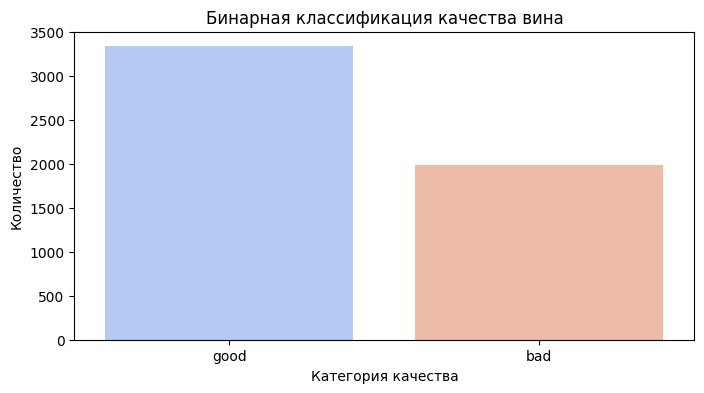

In [31]:
print("=== ОЦЕНКА СБАЛАНСИРОВАННОСТИ КЛАССОВ ===")

# Анализируем баланс классов для качества
print("Сбалансированность классов качества:")
for score in sorted(df['quality'].unique()):
    count = (df['quality'] == score).sum()
    percentage = (count / len(df)) * 100
    print(f"  Качество {score}: {count:4} вин ({percentage:5.1f}%)")

# Создаем бинарную классификацию (хорошее/плохое вино)
def classify_wine_quality(quality):
    if quality >= 6:
        return 'good'
    else:
        return 'bad'

df['quality_binary'] = df['quality'].apply(classify_wine_quality)

print(f"\nБИНАРНАЯ КЛАССИФИКАЦИЯ:")
print(df['quality_binary'].value_counts())
print(f"\nПроцентное соотношение:")
print(df['quality_binary'].value_counts(normalize=True) * 100)

# Визуализация бинарной классификации
plt.figure(figsize=(8, 4))
sns.countplot(x='quality_binary', data=df, palette='coolwarm')
plt.title('Бинарная классификация качества вина')
plt.xlabel('Категория качества')
plt.ylabel('Количество')
plt.show()

In [18]:
features = ['alcohol', 'density', 'volatile acidity', 'citric acid', 
            'residual sugar', 'chlorides', 'free sulfur dioxide', 
            'total sulfur dioxide', 'pH', 'sulphates', 'sweetness_index']

target = 'quality_binary'

X = df[features]
y = df[target]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("=== РАЗДЕЛЕНИЕ ДАННЫХ ===")

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Тестовая выборка: {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

=== РАЗДЕЛЕНИЕ ДАННЫХ ===
Обучающая выборка: 3730 образцов (70.0%)
Тестовая выборка: 1599 образцов (30.0%)

Распределение классов в обучающей выборке:
quality_binary
good    0.626273
bad     0.373727
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
quality_binary
good    0.626642
bad     0.373358
Name: proportion, dtype: float64


In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

print("=== kNN КЛАССИФИКАЦИЯ ===")

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_search_knn.best_params_}")
print(f"Лучшая точность на кросс-валидации: {grid_search_knn.best_score_:.4f}")

# Обучаем модель с лучшими параметрами
knn_best = grid_search_knn.best_estimator_
knn_best.fit(X_train_scaled, y_train)

# Прогноз на тестовой выборке
y_pred_knn = knn_best.predict(X_test_scaled)
y_pred_proba_knn = knn_best.predict_proba(X_test_scaled)[:, 1]  # вероятности для класса 'good'

=== kNN КЛАССИФИКАЦИЯ ===
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Лучшая точность на кросс-валидации: 0.7461


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

print("=== ДЕРЕВО РЕШЕНИЙ ===")

# Поиск оптимальных параметров
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)  # Для деревьев масштабирование не нужно

print(f"Лучшие параметры: {grid_search_dt.best_params_}")
print(f"Лучшая точность на кросс-валидации: {grid_search_dt.best_score_:.4f}")

# Обучаем модель с лучшими параметрами
dt_best = grid_search_dt.best_estimator_
dt_best.fit(X_train, y_train)

# Прогноз на тестовой выборке
y_pred_dt = dt_best.predict(X_test)
y_pred_proba_dt = dt_best.predict_proba(X_test)[:, 1]  # вероятности для класса 'good'

=== ДЕРЕВО РЕШЕНИЙ ===
Лучшие параметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучшая точность на кросс-валидации: 0.7212


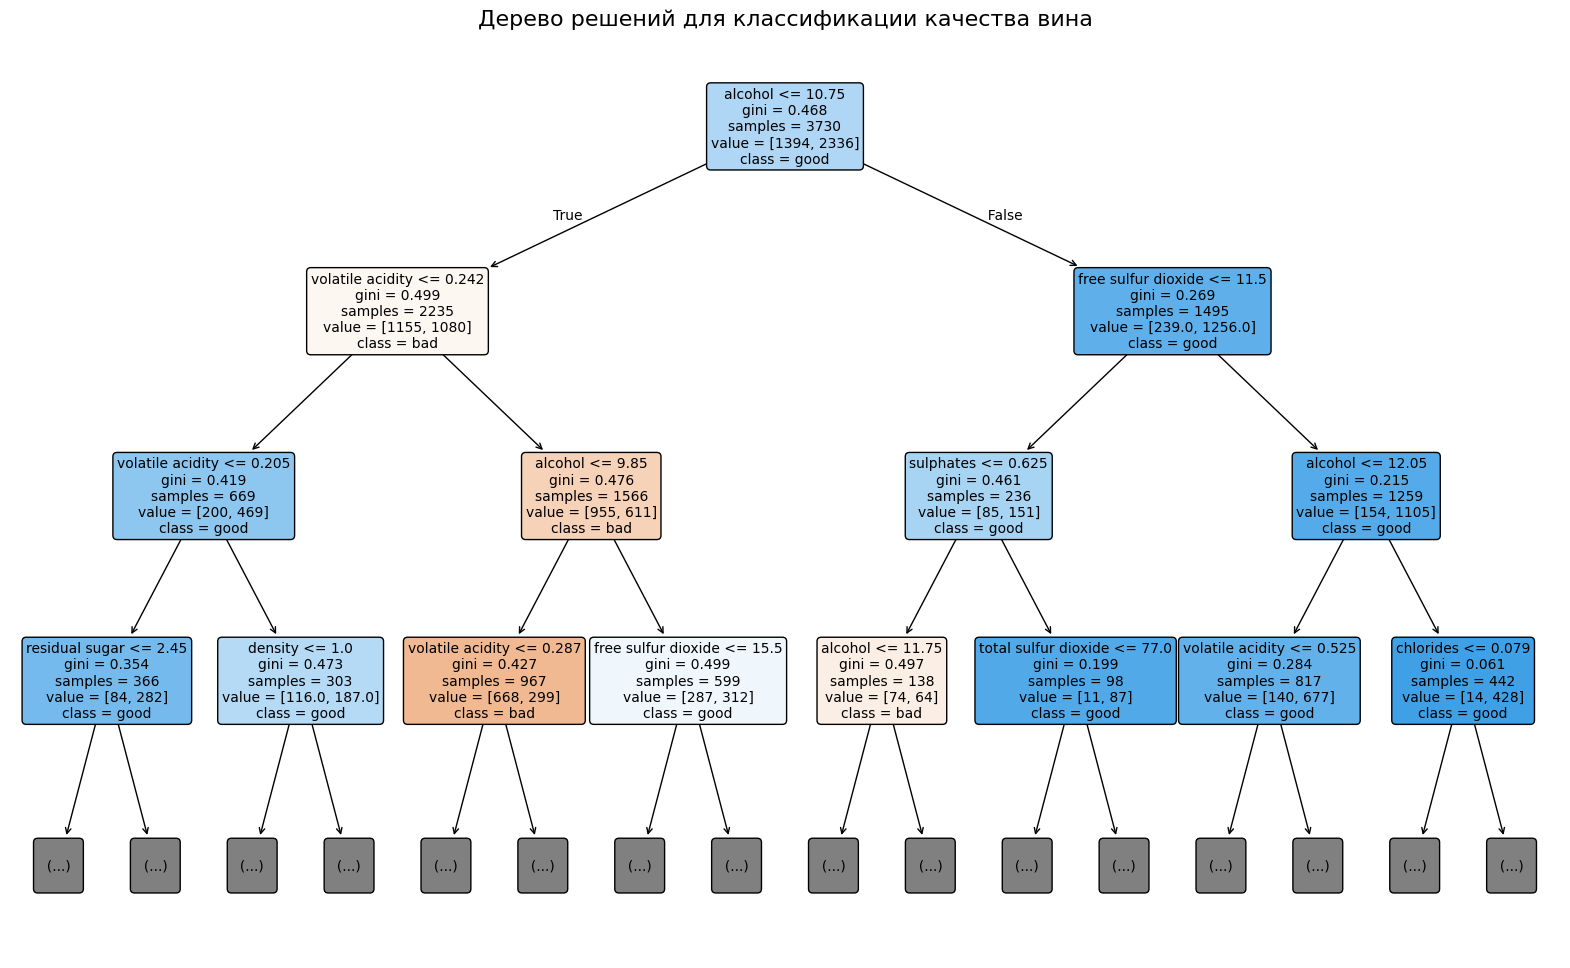

=== ВАЖНОСТЬ ПРИЗНАКОВ В ДЕРЕВЕ РЕШЕНИЙ ===
                 feature  importance
0                alcohol    0.534321
2       volatile acidity    0.215979
9              sulphates    0.113946
6    free sulfur dioxide    0.070136
5              chlorides    0.018735
1                density    0.013949
4         residual sugar    0.010260
7   total sulfur dioxide    0.010249
8                     pH    0.007173
3            citric acid    0.005254
10       sweetness_index    0.000000


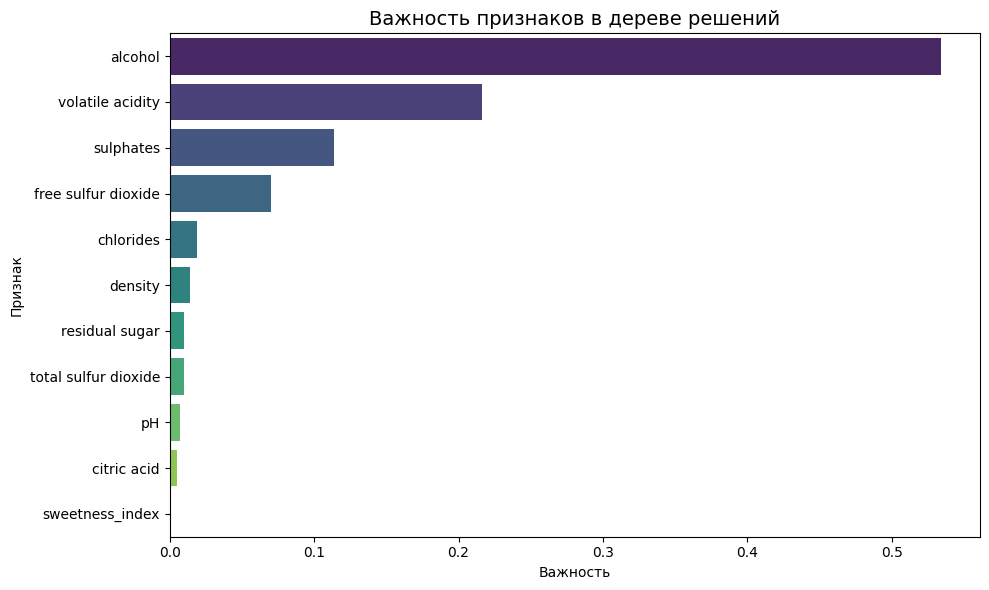

In [22]:
# Визуализация дерева решений
plt.figure(figsize=(20, 12))
tree.plot_tree(dt_best, 
               feature_names=features,
               class_names=['bad', 'good'],
               filled=True,
               rounded=True,
               fontsize=10,
               max_depth=3)  # показываем только 3 уровня для читаемости
plt.title("Дерево решений для классификации качества вина", fontsize=16)
plt.show()

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

print("=== ВАЖНОСТЬ ПРИЗНАКОВ В ДЕРЕВЕ РЕШЕНИЙ ===")
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Важность признаков в дереве решений', fontsize=14)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

In [35]:
print("kNN МЕТРИКИ КАЧЕСТВА:")

# Основные метрики
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, pos_label='good')
recall_knn = recall_score(y_test, y_pred_knn, pos_label='good')
f1_knn = f1_score(y_test, y_pred_knn, pos_label='good')

print(f"Accuracy:  {accuracy_knn:.4f}")
print(f"Precision: {precision_knn:.4f}")
print(f"Recall:    {recall_knn:.4f}")
print(f"F1-Score:  {f1_knn:.4f}")

cm_knn = confusion_matrix(y_test, y_pred_knn, labels=['bad', 'good'])

print("\nМатрица ошибок (Confusion Matrix):")
print(f"          Предсказано")
print(f"          bad  good")
print(f"Истинно bad  {cm_knn[0,0]:4d}  {cm_knn[0,1]:4d}")
print(f"        good {cm_knn[1,0]:4d}  {cm_knn[1,1]:4d}")

kNN МЕТРИКИ КАЧЕСТВА:
Accuracy:  0.7686
Precision: 0.7894
Recall:    0.8603
F1-Score:  0.8233

Матрица ошибок (Confusion Matrix):
          Предсказано
          bad  good
Истинно bad   367   230
        good  140   862


In [37]:
print("\nДЕРЕВО РЕШЕНИЙ МЕТРИКИ КАЧЕСТВА:")

# Основные метрики
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, pos_label='good')
recall_dt = recall_score(y_test, y_pred_dt, pos_label='good')
f1_dt = f1_score(y_test, y_pred_dt, pos_label='good')

print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1-Score:  {f1_dt:.4f}")

cm_dt = confusion_matrix(y_test, y_pred_dt, labels=['bad', 'good'])

print("\nМатрица ошибок (Confusion Matrix):")
print(f"          Предсказано")
print(f"          bad  good")
print(f"Истинно bad  {cm_dt[0,0]:4d}  {cm_dt[0,1]:4d}")
print(f"        good {cm_dt[1,0]:4d}  {cm_dt[1,1]:4d}")


ДЕРЕВО РЕШЕНИЙ МЕТРИКИ КАЧЕСТВА:
Accuracy:  0.7461
Precision: 0.7734
Recall:    0.8413
F1-Score:  0.8059

Матрица ошибок (Confusion Matrix):
          Предсказано
          bad  good
Истинно bad   350   247
        good  159   843



=== СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК ===
      Metric     kNN  Decision Tree
0   Accuracy  0.7686         0.7461
1  Precision  0.7894         0.7734
2     Recall  0.8603         0.8413
3   F1-Score  0.8233         0.8059


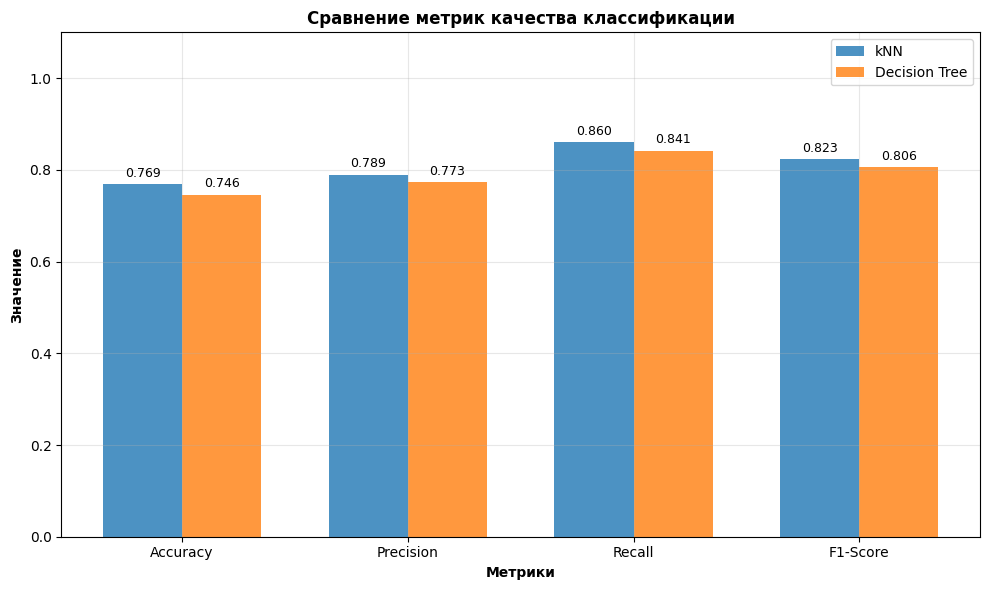

In [26]:
print("\n=== СРАВНИТЕЛЬНАЯ ТАБЛИЦА МЕТРИК ===")

metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'kNN': [accuracy_knn, precision_knn, recall_knn, f1_knn],
    'Decision Tree': [accuracy_dt, precision_dt, recall_dt, f1_dt]
})

print(metrics_comparison.round(4))

# Визуализация сравнения
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics_comparison))
width = 0.35

plt.bar(x - width/2, metrics_comparison['kNN'], width, label='kNN', alpha=0.8)
plt.bar(x + width/2, metrics_comparison['Decision Tree'], width, label='Decision Tree', alpha=0.8)

plt.xlabel('Метрики', fontweight='bold')
plt.ylabel('Значение', fontweight='bold')
plt.title('Сравнение метрик качества классификации', fontweight='bold')
plt.xticks(x, metrics_comparison['Metric'])
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (knn_val, dt_val) in enumerate(zip(metrics_comparison['kNN'], metrics_comparison['Decision Tree'])):
    plt.text(i - width/2, knn_val + 0.01, f'{knn_val:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, dt_val + 0.01, f'{dt_val:.3f}', ha='center', va='bottom', fontsize=9)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

=== ROC-КРИВЫЕ ===


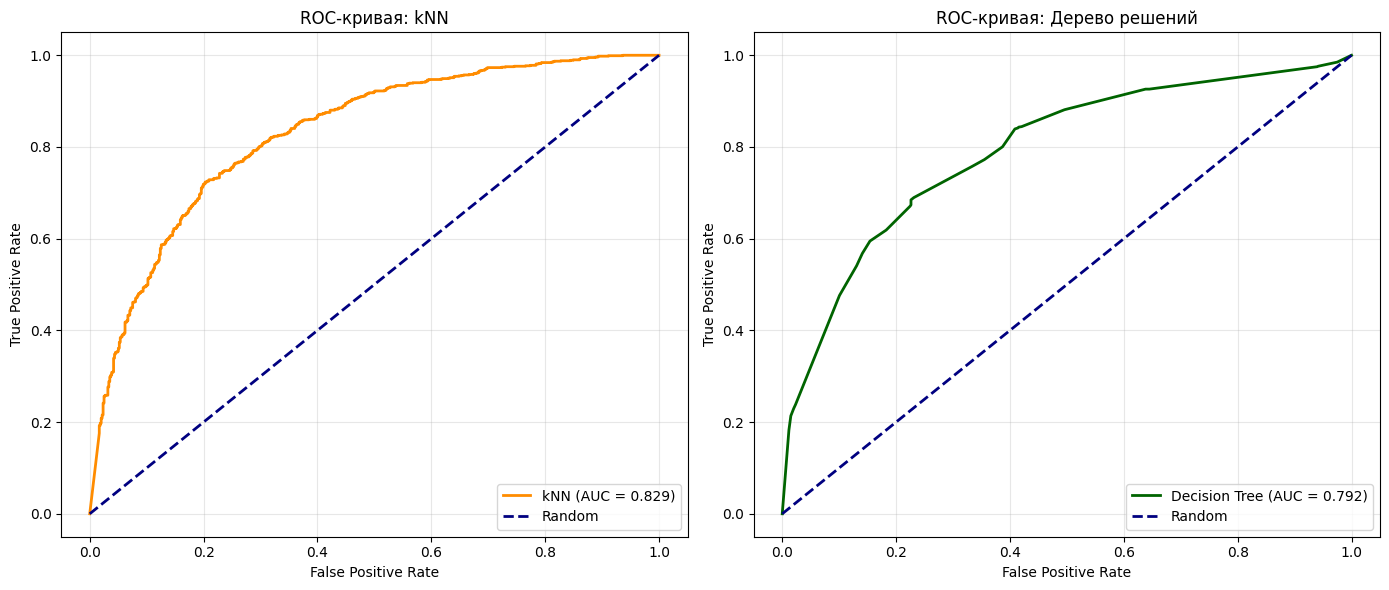

AUC kNN: 0.8289
AUC Дерево решений: 0.7916


In [27]:
print("=== ROC-КРИВЫЕ ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC для kNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn, pos_label='good')
roc_auc_knn = auc(fpr_knn, tpr_knn)

ax1.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, 
         label=f'kNN (AUC = {roc_auc_knn:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-кривая: kNN')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# ROC для дерева решений
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt, pos_label='good')
roc_auc_dt = auc(fpr_dt, tpr_dt)

ax2.plot(fpr_dt, tpr_dt, color='darkgreen', lw=2, 
         label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-кривая: Дерево решений')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"AUC kNN: {roc_auc_knn:.4f}")
print(f"AUC Дерево решений: {roc_auc_dt:.4f}")

Вывод и анализ результатов

В ходе исследования сравнивались два алгоритма классификации: kNN и дерево решений.
Результаты показали, что kNN (76.9% accuracy) превосходит дерево решений (74.6% accuracy) по всем метрикам качества.

Такие результаты мог быть связаны с тем, что kNN лучше подходит для данной задачи, так как классификация качества вин имеет плавные границы между классами, а алгоритм эффективно использует информацию о 'похожих' образцах. Дерево решений, хотя и обеспечивает интерпретируемость (разная важность параметров), уступает в точности из-за создания жёстких границ решений.

Модель может использоваться для предсказания качества вин с точностью около 77%. Также были выявлены параметры, влияние которых наиболее значительно сказывается на качестве вин.